# 1. Import libraries to be used in this notebook

In [1]:
import numpy as np # for array manipulation and basic scientific calculation
import xarray as xr # To read NetCDF files
import matplotlib.pyplot as plt # Core library for plotting
from functions.Calc_Emis import Calc_Emis_T # Emission calculation
from scipy.interpolate import griddata # Simple regridding
from functions.ZonalMeridional import SE_ZonalMeridional # To calculate zonal/meridional mean

# 2. Read files

## 2.1. Model output

In [2]:
Filebase_CONUS = '/glade/campaign/acom/acom-climate/tilmes/CO_CONUS/f.e22.FCcotagsNudged.ne0CONUSne30x8.cesm220.2012-01/atm/hist/f.e22.FCcotagsNudged.ne0CONUSne30x8.cesm220.2012-01.cam.h1.2013-MM.nc'

# Change "MM" to 01~12 for a year calculation
Files_CONUS = [] # empty list for a start
# file list with 12 files
for mm in np.arange(12):
    Files_CONUS.append( Filebase_CONUS.replace('MM',str(mm+1).zfill(2)) )
# read 12 files at once using "mf"dataset
ds_CONUS = xr.open_mfdataset( Files_CONUS ) 


## 2.2. SCRIP file
### SCRIP file has grid information that is needed to calculate area of each grid
### Don't have to read, just locate where the files are

In [3]:
SCRIP_CONUS = '/glade/p/acom/MUSICA/grids/ne0CONUSne30x8/ne0CONUS_ne30x8_np4_SCRIP.nc'

# 3. Emission total

## 3.1. Calculate emissions for 12 months

In [4]:
# Calculate CO emissions - global
CO_Emis_global = Calc_Emis_T( ds_CONUS['SFCO'], print_results=False, 
                              mw=28., scrip_file=SCRIP_CONUS )
# Calculate CO emissions - specify longitudes and latitudes
CO_Emis_CONUS = Calc_Emis_T( ds_CONUS['SFCO'], print_results=False, 
                             mw=28., scrip_file=SCRIP_CONUS, 
                             lon_range=[-130,-60], lat_range=[20,55] )


## 3.2 Draw a simple plot

Text(0.5, 1.0, 'Global CO emissions in 2013')

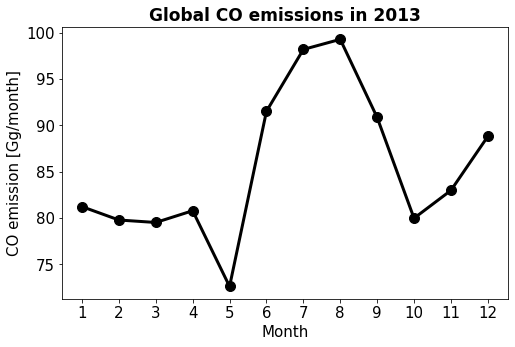

In [5]:
fig = plt.figure( figsize=(8,5) )
ax = fig.add_subplot(1,1,1)

# Plot global monthly CO emissions
ax.plot( np.arange(12)+1, CO_Emis_global.emissions_total/1E9, 'ko-', lw=3, ms=10 )

# === Polish the plot === 
# Font size
ax.set_xticks( np.arange(12)+1 )
plt.setp( ax.get_xticklabels(), fontsize=15 )
plt.setp( ax.get_yticklabels(), fontsize=15 )
# Add x & y axis titles
ax.set_xlabel( 'Month', fontsize=15 )
ax.set_ylabel( 'CO emission [Gg/month]', fontsize=15 )
# Add a plot title
ax.set_title( 'Global CO emissions in 2013', fontsize=17, weight='semibold' )



# 4. Vertical profile

## 4.1. Calculate vertical profile of ozone over the region of interest

In [6]:
# Get the first month using the isel function of xarray
# You can use it for any dimensions such as altitude
ds_CONUS_Jan = ds_CONUS.isel(time=0)


# Colorado region
# Longitude in MUSICAv0 (CESM) is from 0 to 360
lon_range = [251, 258]; lat_range=[37,41]

# Get longitude & latitude
lon = ds_CONUS_Jan['lon'].values
lat = ds_CONUS_Jan['lat'].values

# Get array indices for Colorado, based on center longitude and latitude
Indices = np.where( ( lon >= lon_range[0] ) & ( lon <= lon_range[1] ) \
                  & ( lat >= lat_range[0] ) & ( lat <= lat_range[1] ) )[0]

# Calculate mean ozone profile
# The first dimension is altitude, the second is ncol
# Use np.mean to average it over the whole Colorado region
O3_profile = np.mean( ds_CONUS_Jan['O3'].values[:,Indices], 1 ) * 1e9
# O3S is ozone from stratosphere
O3S_profile = np.mean( ds_CONUS_Jan['O3S'].values[:,Indices], 1 ) * 1e9

# Also get geopotential height for y-axis
Z3_profile = np.mean( ds_CONUS_Jan['Z3'].values[:,Indices], 1 ) / 1e3


## 4.2. Plot vertical profile

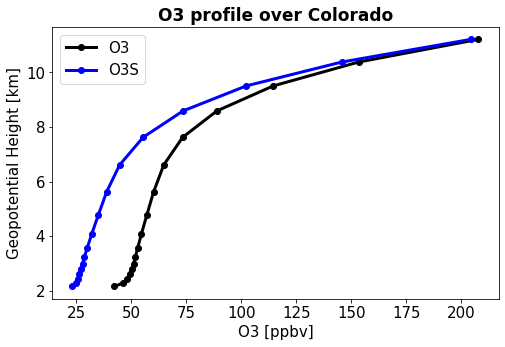

In [7]:
fig = plt.figure( figsize=(8,5) )
ax = fig.add_subplot(1,1,1)

# Plot O3 profile
ax.plot( O3_profile[15:], Z3_profile[15:], 'ko-', lw=3, label='O3' )
ax.plot( O3S_profile[15:], Z3_profile[15:], 'bo-', lw=3, label='O3S' )

# === Polish the plot === 
# Font size
plt.setp( ax.get_xticklabels(), fontsize=15 )
plt.setp( ax.get_yticklabels(), fontsize=15 )
# Add x & y axis titles
ax.set_xlabel( 'O3 [ppbv]', fontsize=15 )
ax.set_ylabel( 'Geopotential Height [km]', fontsize=15 )
# Add a plot title
ax.set_title( 'O3 profile over Colorado', fontsize=17, weight='semibold' )

# Add a legend
ax.legend( fontsize=15, loc=0 )


# 5. Cross section

## 5.1. Regrid data to a traditional lat/lon grid

### This example uses griddata function by Scipy library. 
### For advanced regridding methods, use ESMPy (https://earthsystemmodeling.org/esmpy_doc/release/latest/html/intro.html)

In [8]:
# This will define the lat/lon range we are using to correspond to global 1x1 grid
x = np.linspace(0.5,359.5,360)
y = np.linspace(-89.5,89.5,90)
# This will put lat and lon into arrays, something that is needed for plotting
X, Y = np.meshgrid(x,y)
# Here we are putting the unstructured data onto our defined 1x1 grid using linear interpolation
Regridded_PRECC = griddata( (lon,lat), ds_CONUS_Jan['PRECC'].values, (X, Y), method='linear')
Regridded_PRECL = griddata( (lon,lat), ds_CONUS_Jan['PRECL'].values, (X, Y), method='linear')

# Make zonal-mean
# use nanmean instead of mean to deal with nan values around the pole
# PRECL and PRECC are in m/s. 8.64e7 is used to convert m/s to mm/day
Zmean_PRECC = np.nanmean( Regridded_PRECC, 1 ) * 8.64e7
Zmean_PRECL = np.nanmean( Regridded_PRECL, 1 ) * 8.64e7

## 5.2. Plot meridional cross section

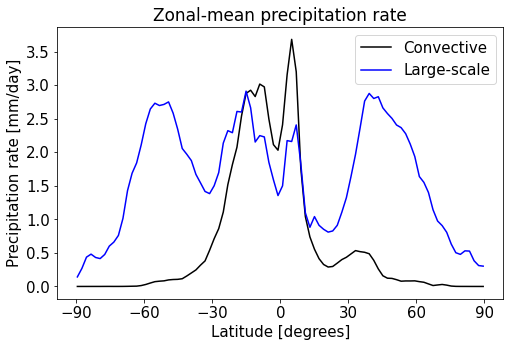

In [9]:
fig = plt.figure( figsize=(8,5) )
ax = fig.add_subplot(1,1,1)

# Plot global monthly CO emissions
ax.plot( y, Zmean_PRECC, 'k-', label='Convective' )
ax.plot( y, Zmean_PRECL, 'b-', label='Large-scale' )

# === Polish the plot === 
# Set x-axis ticks
ax.set_xticks( [-90,-60,-30,0,30,60,90] )
# Font size
plt.setp( ax.get_xticklabels(), fontsize=15 )
plt.setp( ax.get_yticklabels(), fontsize=15 )
# Add x & y axis titles
ax.set_xlabel( 'Latitude [degrees]', fontsize=15 )
ax.set_ylabel( 'Precipitation rate [mm/day]', fontsize=15 )
# Add a plot title
ax.set_title( 'Zonal-mean precipitation rate', fontsize=17 )

# Add a legend
ax.legend( fontsize=15, loc=0 )

## 5.3. Another way to calculate cross section
### This example uses a function that calculates area-weighted zonal/meridional cross section

In [10]:
# Regrid the data for zonal plot to a regular grid with the following resolution
Regridding_res=1.  #in degree

# Get area information
area= ds_CONUS_Jan['area'].values

# PRECL and PRECC are in m/s. 8.64e7 is used to convert m/s to mm/day
PRECC = ds_CONUS_Jan['PRECC'].values* 8.64e7
PRECL = ds_CONUS_Jan['PRECL'].values* 8.64e7

Zmean_PRECC,Z_coord=SE_ZonalMeridional(PRECC,area,lat,Regridding_res) 
Zmean_PRECL,Z_coord=SE_ZonalMeridional(PRECL,area,lat,Regridding_res)


## 5.4. Same as 5.2 but with different regridding method used in 5.3

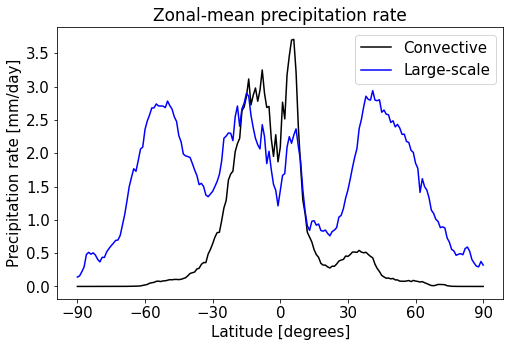

In [11]:
fig = plt.figure( figsize=(8,5) )
ax = fig.add_subplot(1,1,1)

# Plot global monthly CO emissions
ax.plot( Z_coord, Zmean_PRECC, 'k-', label='Convective' )
ax.plot( Z_coord, Zmean_PRECL, 'b-', label='Large-scale' )

# === Polish the plot === 
# Set x-axis ticks
ax.set_xticks( [-90,-60,-30,0,30,60,90] )
# Font size
plt.setp( ax.get_xticklabels(), fontsize=15 )
plt.setp( ax.get_yticklabels(), fontsize=15 )
# Add x & y axis titles
ax.set_xlabel( 'Latitude [degrees]', fontsize=15 )
ax.set_ylabel( 'Precipitation rate [mm/day]', fontsize=15 )
# Add a plot title
ax.set_title( 'Zonal-mean precipitation rate', fontsize=17 )

# Add a legend
ax.legend( fontsize=15, loc=0 )